In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

In [3]:
path = '/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/dataset/'

In [4]:
import pandas as pd

train_df = pd.read_csv(os.path.join(path, 'my_train.csv'))
test_df = pd.read_csv(os.path.join(path, 'my_test.csv'))

In [5]:
train_df.head()

,filename,width,height,x,y,w,h,label
0,0001.jpg,640,423,20.0,75.0,521.0,298.0,1
1,0002.jpg,1992,1328,231.9,249.4,1691.6,893.7,3
2,0003.jpg,600,440,87.0,68.0,417.0,319.0,2
3,0004.jpg,1600,1065,382.5,141.0,1107.5,836.2,2
4,0005.jpg,800,450,62.5,133.2,491.9,314.4,3


In [6]:
test_df.head()

,filename,width,height,x,y,w,h,label
0,1205.jpg,640,426,230.0,76.0,388.0,259.0,1
1,1205.jpg,640,426,70.0,250.0,126.0,93.0,1
2,1205.jpg,640,426,134.0,128.0,308.0,195.0,1
3,1206.jpg,640,427,333.0,118.0,235.0,302.0,3
4,1206.jpg,640,427,137.0,85.0,150.0,315.0,3


In [7]:
train_df.groupby('filename').agg(['count'])['label']

,count
filename,
0001.jpg,1
0002.jpg,1
0003.jpg,1
0004.jpg,1
0005.jpg,3
...,...
1200.jpg,2
1201.jpg,1
1202.jpg,1


In [8]:
f_train = list(train_df['filename'].unique())

In [9]:
multi_labels = []
for f in f_train:
  labels = set(list(train_df[train_df['filename'] == f]['label']))
  
  if len(labels) > 1:
    print(f, labels)
    multi_labels.append(f)

0015.jpg {1, 3}
0037.jpg {1, 3}
0194.jpg {0, 3}
0250.jpg {1, 3}
0254.jpg {1, 3}
0393.jpg {0, 3}
0414.jpg {0, 2}
0490.jpg {0, 3}
0713.jpg {0, 3}
0763.jpg {1, 3}
0859.jpg {1, 2}
0863.jpg {0, 1}
0912.jpg {1, 2}
1030.jpg {0, 3}
1084.jpg {0, 3}
1121.jpg {0, 1, 3}


In [10]:
print(len(multi_labels))

16


In [11]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 40.20 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [12]:
!ls

detr  drive  sample_data


In [13]:
!pip install albumentations==0.4.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.5-py3-none-any.whl size=64372 sha256=add2fd1491544b2970448df82ea999d8c7b22e5d95185220ec605512d9958e74
  Stored in directory: /root/.cache/pip/wheels/be/0c/f1/be15b7c7025416665227294d983a5405c8fde17427c0abb05d
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654003 sha256=a77b2cd588232d7c5b130481e5691247e576ae43676f1d0fb59b76a323b99200
  Stored in directory: /root/.cache/pip/wheels/cb/c7/a6/2d7a113c4885dc0f4eacd8f41095763181c0b9a18223ac7533
Successfully built albumentations imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Unin

In [14]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

<ipython-input-14-d875a0c87f69>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [15]:
print(A.__version__)

0.4.5


# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

In [17]:
n_folds = 5
seed = 42
num_classes = 5
num_queries = 100 # EDA 해서 max_bb 찾기
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 100

# Seed Everything

Seeding everything for reproducible results

In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [19]:
seed_everything(seed)

# Preparing the Data

* For preparation of data I use code from Alex's awesome kernel [here](https://www.kaggle.com/shonenkov/training-efficientdet)
* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [20]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = train_df[['filename']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('filename').count()
df_folds.loc[:, 'label'] = train_df[['filename', 'label']].groupby('filename').min()['label']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['label'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [21]:
df_folds

,bbox_count,label,stratify_group,fold
filename,,,,
0001.jpg,1,1,1_0,2
0002.jpg,1,3,3_0,4
0003.jpg,1,2,2_0,1
0004.jpg,1,2,2_0,4
0005.jpg,3,3,3_0,2
...,...,...,...,...
1200.jpg,2,1,1_0,4
1201.jpg,1,0,0_0,4
1202.jpg,1,1,1_0,1


# Augmentations

* As suggested by aleksendra in her kernel ,augentations will play a major role and hence took her up advice and use awesome augmentations , cut-mix and other will be included in future versions

In [22]:
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9), # RGB 임의로 shuffling
                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),
                      
                      A.ToGray(p=0.01),
                      
                      A.HorizontalFlip(p=0.5),
                      
                      A.VerticalFlip(p=0.5),
                      # https://leedakyeong.tistory.com/entry/Python-albumentations-%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-Image-Agumentation,
                      A.LongestMaxSize (max_size=512),
                      A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT), 
                       
                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5), # 사진의 일부를 지우고 0으로 채움
                      
                      ToTensorV2(p=1.0)],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels']) # 바운딩 박스 표기법 yolo
                      )

def get_valid_transforms():
    return A.Compose([ A.LongestMaxSize (max_size=512),
                       A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                       ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

# Creating Dataset

* I hope you have the video by now , DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [23]:
DIR_TRAIN = '/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/dataset/train'

class CustomDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3] # w * h
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)

        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [24]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True) # pretrained된 DETR 모델
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [25]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache

In [26]:
model

DETRModel(
  (model): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
           

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [27]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

# Training Function

Training of DETR is unique and different from FasteRRcnn  and EfficientDET , as we train the criterion as well , the training function can be viewed here : https://github.com/facebookresearch/detr/blob/master/engine.py

In [28]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

# Eval Function

In [29]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

# Engine

In [30]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [31]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = CustomDataset(
    image_ids=df_train.index.values,
    dataframe=train_df,
    transforms=get_train_transforms()
    )

    valid_dataset = CustomDataset(
    image_ids=df_valid.index.values,
    dataframe=train_df,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/detr_best_{fold}.pth')

In [32]:
df_folds[df_folds['fold'] != 0].index.values[0]

'0001.jpg'

In [33]:
run(fold=0)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 1| TRAIN_LOSS 1.5867497812617908| VALID_LOSS 1.1942896881411154|
Best model found for Fold 0 in Epoch 1........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 2| TRAIN_LOSS 1.091163130338527| VALID_LOSS 1.0860239853782039|
Best model found for Fold 0 in Epoch 2........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 3| TRAIN_LOSS 0.9006550041112033| VALID_LOSS 0.7463582138861379|
Best model found for Fold 0 in Epoch 3........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 4| TRAIN_LOSS 0.7450752245985772| VALID_LOSS 0.6546729437766536|
Best model found for Fold 0 in Epoch 4........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 5| TRAIN_LOSS 0.6399105991706375| VALID_LOSS 0.6039060652256012|
Best model found for Fold 0 in Epoch 5........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 6| TRAIN_LOSS 0.6323598662683786| VALID_LOSS 0.6050007324064931|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 7| TRAIN_LOSS 0.5621901632340487| VALID_LOSS 0.520215759354253|
Best model found for Fold 0 in Epoch 7........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 8| TRAIN_LOSS 0.5413870924760488| VALID_LOSS 0.5080180629607169|
Best model found for Fold 0 in Epoch 8........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 9| TRAIN_LOSS 0.5026974532722441| VALID_LOSS 0.46569156166045894|
Best model found for Fold 0 in Epoch 9........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 10| TRAIN_LOSS 0.4720546893837038| VALID_LOSS 0.43162427602275727|
Best model found for Fold 0 in Epoch 10........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 11| TRAIN_LOSS 0.4455371358670479| VALID_LOSS 0.4193733834451245|
Best model found for Fold 0 in Epoch 11........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 12| TRAIN_LOSS 0.42715149329713553| VALID_LOSS 0.4221296512311505|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 13| TRAIN_LOSS 0.47589400312132085| VALID_LOSS 0.4203580714041187|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 14| TRAIN_LOSS 0.437475347691331| VALID_LOSS 0.3970967569658833|
Best model found for Fold 0 in Epoch 14........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 15| TRAIN_LOSS 0.40231988560562293| VALID_LOSS 0.3702784920892408|
Best model found for Fold 0 in Epoch 15........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 16| TRAIN_LOSS 0.41810688511891797| VALID_LOSS 0.37781917087493405|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 17| TRAIN_LOSS 0.4209968657040399| VALID_LOSS 0.40810327087679216|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 18| TRAIN_LOSS 0.43999930551229427| VALID_LOSS 0.39490741202908175|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 19| TRAIN_LOSS 0.3887687672760861| VALID_LOSS 0.35825935294551237|
Best model found for Fold 0 in Epoch 19........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 20| TRAIN_LOSS 0.39409715405180434| VALID_LOSS 0.3401479701842031|
Best model found for Fold 0 in Epoch 20........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 21| TRAIN_LOSS 0.41617310293449844| VALID_LOSS 0.4741000859968124|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 22| TRAIN_LOSS 0.4115099719733246| VALID_LOSS 0.4153059999788961|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 23| TRAIN_LOSS 0.43947058103301306| VALID_LOSS 0.41743395020884855|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 24| TRAIN_LOSS 0.4095395217257098| VALID_LOSS 0.38712087369734244|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 25| TRAIN_LOSS 0.4181514196405726| VALID_LOSS 0.3790011800104572|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 26| TRAIN_LOSS 0.4233875817750111| VALID_LOSS 0.392400780031758|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 27| TRAIN_LOSS 0.3862579994457812| VALID_LOSS 0.35936279450693437|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 28| TRAIN_LOSS 0.40018073586392994| VALID_LOSS 0.35646197295958|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 29| TRAIN_LOSS 0.38178533685108845| VALID_LOSS 0.3269138590943429|
Best model found for Fold 0 in Epoch 29........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 30| TRAIN_LOSS 0.3620760816434198| VALID_LOSS 0.3309898256294189|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 31| TRAIN_LOSS 0.35798163502669533| VALID_LOSS 0.2881932679203249|
Best model found for Fold 0 in Epoch 31........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 32| TRAIN_LOSS 0.3505215243367124| VALID_LOSS 0.2911745761671374|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 33| TRAIN_LOSS 0.3426406063324164| VALID_LOSS 0.27232721207603333|
Best model found for Fold 0 in Epoch 33........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 34| TRAIN_LOSS 0.33567052808674896| VALID_LOSS 0.2852978514086816|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 35| TRAIN_LOSS 0.356899211721972| VALID_LOSS 0.5133980137686576|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 36| TRAIN_LOSS 0.434567937673616| VALID_LOSS 0.3043945768187123|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 37| TRAIN_LOSS 0.3564189716804126| VALID_LOSS 0.2730327892688013|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 38| TRAIN_LOSS 0.3294817079936177| VALID_LOSS 0.29780861495002625|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 39| TRAIN_LOSS 0.3299562027139112| VALID_LOSS 0.27225719776845747|
Best model found for Fold 0 in Epoch 39........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 40| TRAIN_LOSS 0.4533039181193044| VALID_LOSS 0.4462836331898166|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 41| TRAIN_LOSS 0.4797685821194294| VALID_LOSS 0.40399113249394203|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 42| TRAIN_LOSS 0.44264926447356046| VALID_LOSS 0.6489740552440766|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 43| TRAIN_LOSS 0.5181594451596915| VALID_LOSS 0.39513185187693567|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 44| TRAIN_LOSS 0.4339415495060692| VALID_LOSS 0.3540901414329006|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 45| TRAIN_LOSS 0.3805881241136346| VALID_LOSS 0.29897439912442236|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 46| TRAIN_LOSS 0.38849744126816427| VALID_LOSS 0.326457308184716|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 47| TRAIN_LOSS 0.36715486362453337| VALID_LOSS 0.3245420407864355|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 48| TRAIN_LOSS 0.36572900673082054| VALID_LOSS 0.39309442043304443|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 49| TRAIN_LOSS 0.40956749071267023| VALID_LOSS 0.3643770059270243|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 50| TRAIN_LOSS 0.36858686398376117| VALID_LOSS 0.2955075858100768|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 51| TRAIN_LOSS 0.33696145139449885| VALID_LOSS 0.2753859431512894|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 52| TRAIN_LOSS 0.34214531340874915| VALID_LOSS 0.28027411333976254|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 53| TRAIN_LOSS 0.33388730427942986| VALID_LOSS 0.2635249038857798|
Best model found for Fold 0 in Epoch 53........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 54| TRAIN_LOSS 0.32087864486639167| VALID_LOSS 0.2608141206925915|
Best model found for Fold 0 in Epoch 54........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 55| TRAIN_LOSS 0.3180608557275504| VALID_LOSS 0.260367370300716|
Best model found for Fold 0 in Epoch 55........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 56| TRAIN_LOSS 0.31316503636107956| VALID_LOSS 0.26166085538364225|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 57| TRAIN_LOSS 0.3122108626094731| VALID_LOSS 0.25646264658820245|
Best model found for Fold 0 in Epoch 57........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 58| TRAIN_LOSS 0.3232680939692111| VALID_LOSS 0.32644260746817433|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 59| TRAIN_LOSS 0.35796709284802114| VALID_LOSS 0.28745282753821344|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 60| TRAIN_LOSS 0.328491812648852| VALID_LOSS 0.25794204108176694|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 61| TRAIN_LOSS 0.316764164931518| VALID_LOSS 0.268730933147092|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 62| TRAIN_LOSS 0.3085583206420102| VALID_LOSS 0.2519990720095173|
Best model found for Fold 0 in Epoch 62........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 63| TRAIN_LOSS 0.3082715494573609| VALID_LOSS 0.23429181402729404|
Best model found for Fold 0 in Epoch 63........Saving Model


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 64| TRAIN_LOSS 0.3271994610463292| VALID_LOSS 0.42663682131998|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 65| TRAIN_LOSS 0.3921637179191447| VALID_LOSS 0.2806775557898706|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 66| TRAIN_LOSS 0.36940357064412643| VALID_LOSS 0.3266862582775854|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 67| TRAIN_LOSS 0.3915317446486024| VALID_LOSS 0.32352995968634085|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 68| TRAIN_LOSS 0.400954545898871| VALID_LOSS 0.39906997954653156|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 69| TRAIN_LOSS 0.34982378165091366| VALID_LOSS 0.2948178324487902|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 70| TRAIN_LOSS 0.34012336388599773| VALID_LOSS 0.3037800452401561|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 71| TRAIN_LOSS 0.3300634287605601| VALID_LOSS 0.29090269486750325|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 72| TRAIN_LOSS 0.3141488700119917| VALID_LOSS 0.26859983994114783|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 73| TRAIN_LOSS 0.31733065412556827| VALID_LOSS 0.2537164952485792|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 74| TRAIN_LOSS 0.3231388215930009| VALID_LOSS 0.270178537214956|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 75| TRAIN_LOSS 0.31560409610921686| VALID_LOSS 0.2972146964842273|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 76| TRAIN_LOSS 0.33022173845078334| VALID_LOSS 0.265790376331537|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 77| TRAIN_LOSS 0.30540665639333486| VALID_LOSS 0.2541745021458595|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 78| TRAIN_LOSS 0.30672210270215655| VALID_LOSS 0.2603375854030732|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 79| TRAIN_LOSS 0.3167560808668452| VALID_LOSS 0.3158564702157051|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 80| TRAIN_LOSS 0.3421938360229997| VALID_LOSS 0.47142128790578536|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 81| TRAIN_LOSS 0.44658304541564187| VALID_LOSS 0.32993836556711503|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 82| TRAIN_LOSS 0.33123389132751907| VALID_LOSS 0.27863037826553466|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 83| TRAIN_LOSS 0.324229211846659| VALID_LOSS 0.2902111098650963|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 84| TRAIN_LOSS 0.31095346291203146| VALID_LOSS 0.27492763775010265|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 85| TRAIN_LOSS 0.29546401625083496| VALID_LOSS 0.2595136225704224|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 86| TRAIN_LOSS 0.2954632283981181| VALID_LOSS 0.26272514101959044|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 87| TRAIN_LOSS 0.3027599027826766| VALID_LOSS 0.26565728024128943|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 88| TRAIN_LOSS 0.30295799167688225| VALID_LOSS 0.2855906428829316|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 89| TRAIN_LOSS 0.342000311810123| VALID_LOSS 0.3131718582683994|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 90| TRAIN_LOSS 0.3374317267463227| VALID_LOSS 0.3057886261132456|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 91| TRAIN_LOSS 0.31060852873916467| VALID_LOSS 0.26764488748965726|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 92| TRAIN_LOSS 0.30664053879493525| VALID_LOSS 0.25303986632535536|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 93| TRAIN_LOSS 0.3516511983615308| VALID_LOSS 0.27825075267784055|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 94| TRAIN_LOSS 0.30298523641814873| VALID_LOSS 0.25127198282749424|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 95| TRAIN_LOSS 0.28744028176157926| VALID_LOSS 0.26579196378588676|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 96| TRAIN_LOSS 0.2928945428330051| VALID_LOSS 0.26632553363038647|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 97| TRAIN_LOSS 0.2711349416616534| VALID_LOSS 0.24709303725150325|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 98| TRAIN_LOSS 0.2716968334164501| VALID_LOSS 0.24770567758429435|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 99| TRAIN_LOSS 0.3024313655520274| VALID_LOSS 0.264545036900428|


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

|EPOCH 100| TRAIN_LOSS 0.36627244555260524| VALID_LOSS 0.31744573145143445|


# Sample

* I know we might be naive to visualize the model ouput just after one epoch but lets do that and see what are the results like

In [34]:
def view_sample(df_valid,model,device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = CustomDataset(image_ids=df_valid.index.values,
                                 dataframe=train_df,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    # print('======')
    # print(len(oboxes))
    # print('-=======')
    for box,p in zip(oboxes,prob):
        print(p)
        if p > 0.5:
            color = (0,0,220) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)
    
    ax.set_axis_off()
    ax.imshow(sample)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


5.4604545e-05
0.0034397724
0.00035763136
0.00039166663
0.0006916385
0.0010015522
0.0035399746
0.0005766393
0.00010613058
0.00023381042
0.0007757971
5.9644608e-05
0.00031869477
0.0003967784
0.007822785
0.00024891042
9.198501e-05
0.0008719644
0.0006839465
0.00061969674
0.0005553356
0.0005876003
0.00033124242
0.00019248495
0.00063191034
0.00035901164
0.00026910965
0.00032766117
0.00031454608
7.664903e-05
0.00012150819
0.01780674
0.00010390495
0.0005396526
0.00037970548
0.00433062
0.00056220975
0.0007066677
0.00714933
0.0005435484
0.0008104107
0.0002945357
0.0024801807
0.00038810747
0.000365323
0.00024778157
0.00074259366
0.0008044914
0.00032063524
0.003759472
9.459629e-05
0.00063688605
0.001035594
0.00043425136
0.00044749162
0.00044799809
0.00028675122
0.0026533457
0.0021207833
0.003739225
0.0005020344
0.97436565
0.000200512
0.00020980363
0.00042774886
0.00044379444
0.00033623027
0.0005932084
0.0009193767
8.481588e-05
0.00058647536
0.00033799422
0.00056549156
0.00046449224
0.0005803395
0.

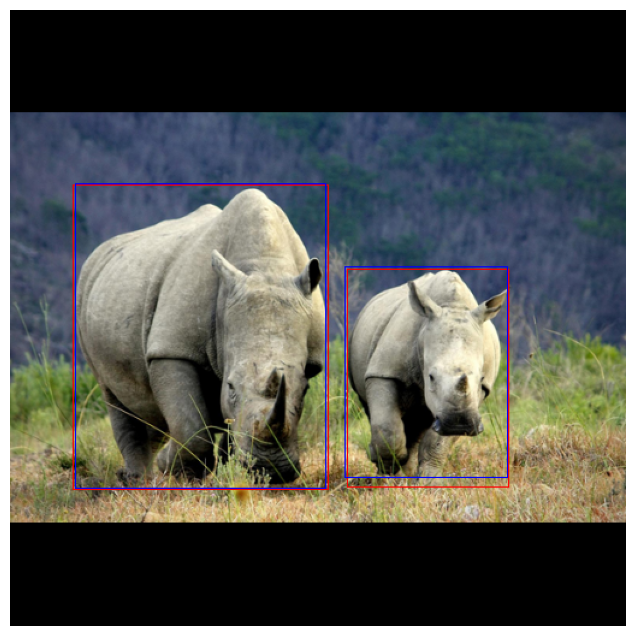

In [35]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/detr_best_0.pth"))
view_sample(df_folds[df_folds['fold'] == 0],model=model,device=torch.device('cuda'))